In [1]:
import math
import numpy as np
import networkx as nx
import pandas as pd
from collections import Counter
import operator

import config
from config import load_users_dataframe
from config import load_networkx_all
from config import load_networkx_friends
from config import load_networkx_potential

# Plotting
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Networkx
from networkx.drawing.nx_agraph import graphviz_layout
import dzcnapy_plotlib as dzcnapy

project_name = config.settings['data']['eventname']
timeframe = config.settings['timeframe']
save_to_file = config.settings['save_to_file'] == 'True'
window = 30
unique_users = load_users_dataframe()
network_all = load_networkx_all()
network_friends = load_networkx_friends()
network_potential = load_networkx_potential()

{'calculate': {'analysis': True,
               'friends': False,
               'network': True,
               'uniquetweets': True,
               'uniqueusers': True},
 'data': {'dates': ['2018-03-11', '2018-03-12', '2018-03-13'],
          'eventname': "Givenchy's Death",
          'phrases': ['givenchy%20death', 'givenchy%20passed%20away'],
          'starttime': 'Mar 12 08:20:00 -0500 2018'},
 'path': {'cwd': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy',
          'networkx': {'all': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/networkx_all.dat',
                       'friends': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/networkx_friends.dat',
                       'potential': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/networkx_potential.dat'},
          'newcrawl': '/Users/lzhou/git/github/uclresearchanalysis/other/newcrawl.dat',
          'pickle': {'friends': '/Users/lzhou/git/github/uclresea

# Basic Info

In [84]:
depth = max(unique_users.generation) + 1
total_nodes = len(network_all.nodes())
top10seeds = unique_users.seed_index.value_counts()[0:10]
top10earliesseeds = unique_users[unique_users.generation == 0][0:10]
top10degree = sorted(dict(nx.degree(network_all)).items(), key=operator.itemgetter(1), reverse=True)[0:10]

# Code

In [119]:
def store_basic_info():
    if save_to_file:
        f = open(config.settings['path']['result']+'/basicinfo.md','w')
    else:
        f = None
    print('==================Results==================', file=f)
    print('* Spreading network:', file=f)
    print('# nodes: {}'.format(len(network_all.nodes())), file=f)
    print('# edges: {}'.format(len(network_all.edges())), file=f)
    depth = max(unique_users.generation) + 1
    print('Generation depth: {}'.format(depth), file=f)
    for i in range(depth):
        print('Generation {}, contains {} users'.format(i, len(unique_users[unique_users.generation == i])), file=f)
    print('** Top 10 seeds with the greatest descendants', file=f)
    top10seeds = unique_users.seed_index.value_counts()[0:10]
    for key in top10seeds.keys():
        print('seed id: {}, {}, # descendants: {}, # descendants in friends network: {}'.format(
            key, 
            network_all.nodes()[key]['user'],
            len(nx.descendants(network_all, key)),
            len(nx.descendants(network_friends, key))
        ), file=f)
    print('** Top 10 seeds closest to event', file=f)
    for key in list(top10earliesseeds.index):
        print('seed id: {}, {}, # descendants: {}, # descendants in friends network: {}'.format(
            key, 
            network_all.nodes()[key]['user'],
            len(nx.descendants(network_all, key)),
            len(nx.descendants(network_friends, key))
        ), file=f)
    top10degree = sorted(dict(nx.degree(network_all)).items(), key=operator.itemgetter(1), reverse=True)[0:10]
    print('** Top 10 nodes with largest degree', file=f)
    for key, degree in top10degree:
        print('node id: {}, {}, degree: {}, degree in friends network: {}, # descendants: {}, # descendants in friends network: {}'.format(
            key,
            network_all.nodes()[key]['user'],
            network_all.degree(key),
            network_friends.degree(key),
            len(nx.descendants(network_all, key)),
            len(nx.descendants(network_friends, key))
        ), file=f)
    print('* Friends network:', file=f)
    print('# nodes: {}'.format(len(network_friends.nodes())), file=f)
    print('# edges: {}'.format(len(network_friends.edges())), file=f)
    print('Graph Density [edge/(node*(node-1))]: {0:.2%}'.format(nx.density(network_friends)), file=f)
    print('============== End of Results==============', file=f)
    # seed的generation分布
    if save_to_file:
        f.close()

def get_colors(depth):
    return sns.cubehelix_palette(depth, start=3, rot=1, reverse=True)
    sns.palplot(colors)

def plot_network(graph, title):
    plt.axis('off')
    pos = graphviz_layout(graph)
    nx.draw_networkx(graph, pos=pos, with_labels=False, **dzcnapy.small_attrs)
    depth = max(nx.get_node_attributes(graph,'generation').values()) + 1
    colors = get_colors(depth)
    color = [colors[graph.node[n]["generation"]] for n in graph]
    dzcnapy.small_attrs["node_color"] = color
    patchList = []
    for index in range(depth):
        data_key = mpatches.Patch(color=colors[index], label='Generation {}'.format(index))
        patchList.append(data_key)
    plt.legend(handles=patchList)
    dzcnapy.set_extent(pos, plt)
    dzcnapy.plot(title, [15, 15], save=True)

# Overview

In [120]:
store_basic_info()

==================Results==================
* Spreading network:
# nodes: 5011
# edges: 4912
Generation depth: 6
Generation 0, contains 99 users
Generation 1, contains 851 users
Generation 2, contains 3227 users
Generation 3, contains 286 users
Generation 4, contains 545 users
Generation 5, contains 3 users
** Top 10 seeds with the greatest descendants
seed id: 21, Fashionista_com, # descendants: 4401, # descendants in friends network: 4906
seed id: 0, davelackie, # descendants: 346, # descendants in friends network: 4906
seed id: 888, miuyorker, # descendants: 67, # descendants in friends network: 4906
seed id: 81, ninatypewriter, # descendants: 19, # descendants in friends network: 4906
seed id: 1748, SteveKoehler22, # descendants: 17, # descendants in friends network: 4906
seed id: 416, TalkFilmSoc, # descendants: 13, # descendants in friends network: 4906
seed id: 1673, InterviewMag, # descendants: 13, # descendants in friends network: 4916
seed id: 3291, TheTodayShow, # descendant

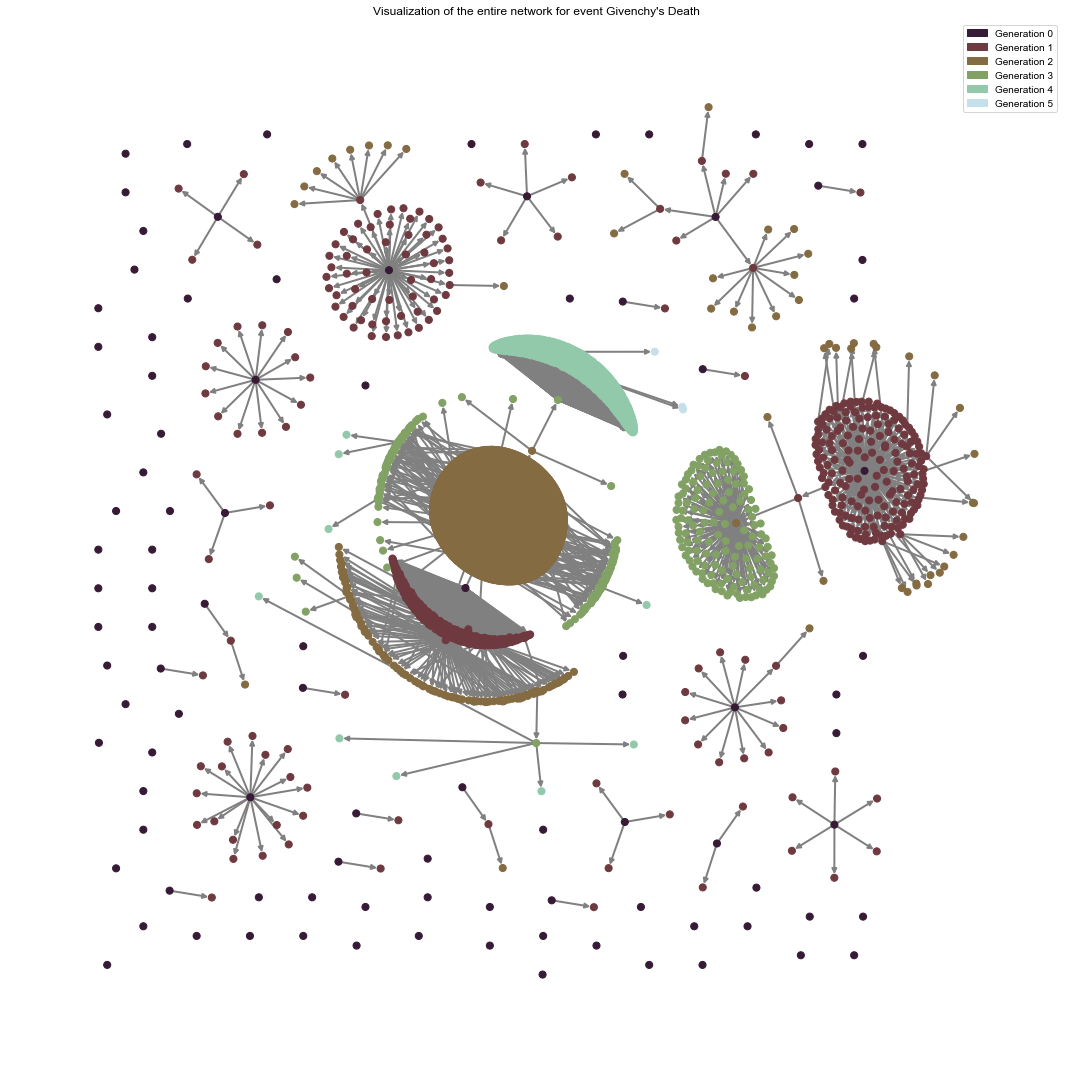

In [83]:
plot_network(network_all, 'Visualization of the entire network for event {}'.format(project_name))

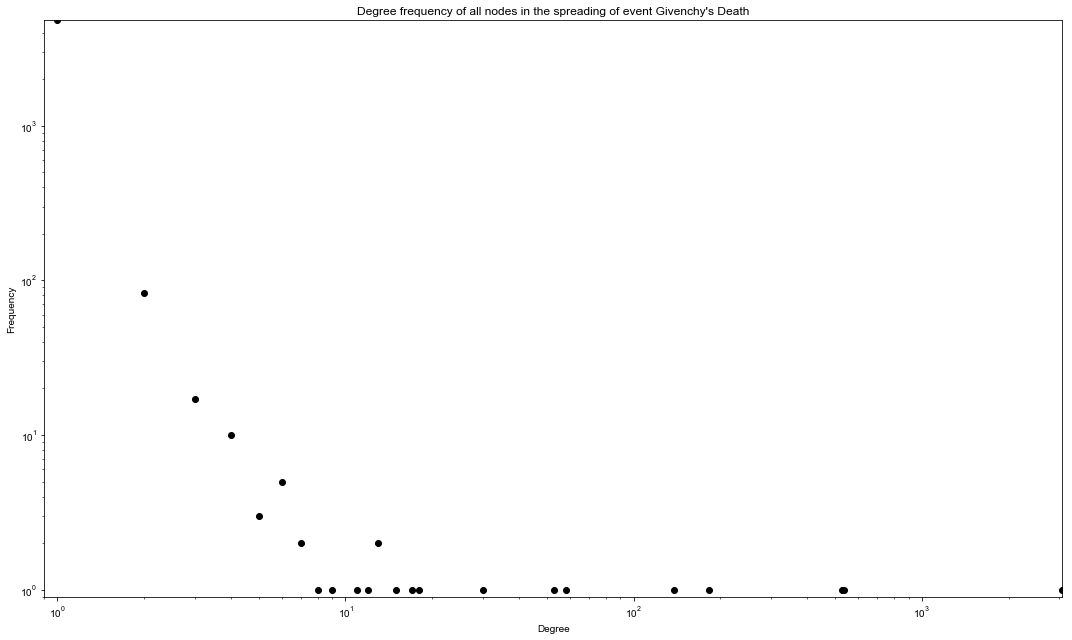

In [19]:
def plot_degree_frequency(network):
    title = 'Degree frequency of all nodes in the spreading of event {}'.format(project_name)
    deg = nx.degree(network_all)
    x, y = zip(*Counter(dict(deg).values()).items())
    plt.scatter(x, y)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(0.9, max(x))
    plt.ylim(0.9, max(y))
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    dzcnapy.plot(title, [15, 9], save=True)
plot_degree_frequency(network_all)

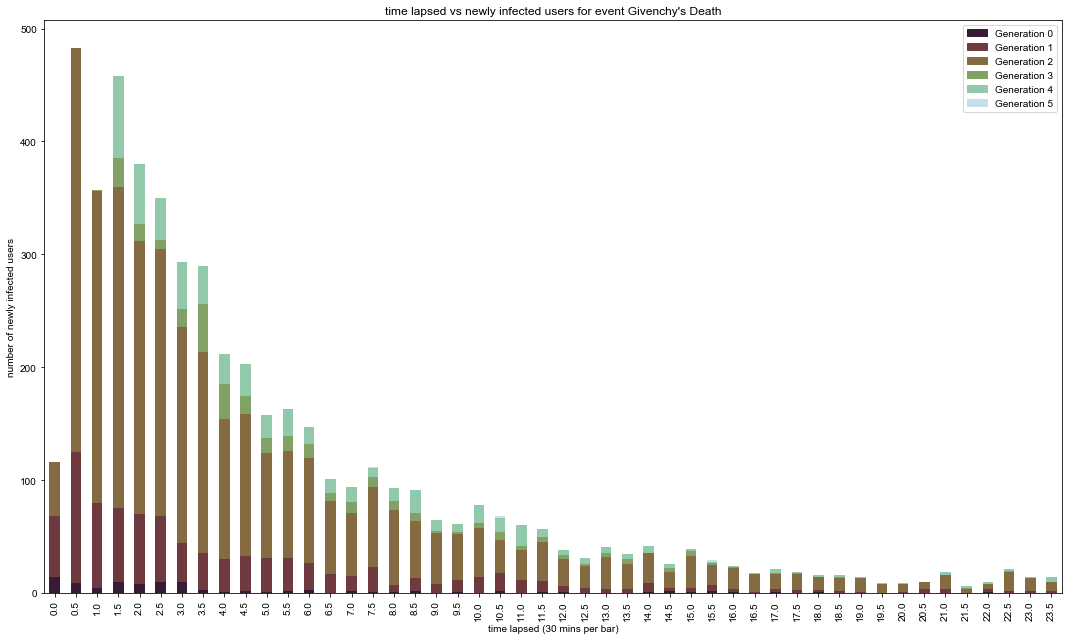

In [17]:
def plot_time_lapsed_vs_newly_infected_users():
    title = 'time lapsed vs newly infected users for event {}'.format(project_name)
    d = pd.DataFrame(0, index=np.arange(int(timeframe)/window), columns=range(depth))
    for i in range(int(int(timeframe)/window)):
        data = unique_users[(unique_users.time_lapsed >= (i)*window) & (unique_users.time_lapsed < (i+1)*window)]
        for generation in range(depth):
            d.iloc[i, generation] = sum(data.generation == generation)
    colors = get_colors(depth)
    ax = d.plot.bar(
        stacked=True, 
        color = colors
    );
    ax.set_xticks(range(48))
    ax.set_xticklabels([i*0.5 for i in range(48)])
    ax.set_xlabel('time lapsed (30 mins per bar)')
    ax.set_ylabel('number of newly infected users')
    patchList = []
    for index in range(depth):
        data_key = mpatches.Patch(color=colors[index], label='Generation {}'.format(index))
        patchList.append(data_key)
    plt.legend(handles=patchList)
    dzcnapy.plot(title, [15, 9], save=True)
plot_time_lapsed_vs_newly_infected_users()

# Seeds

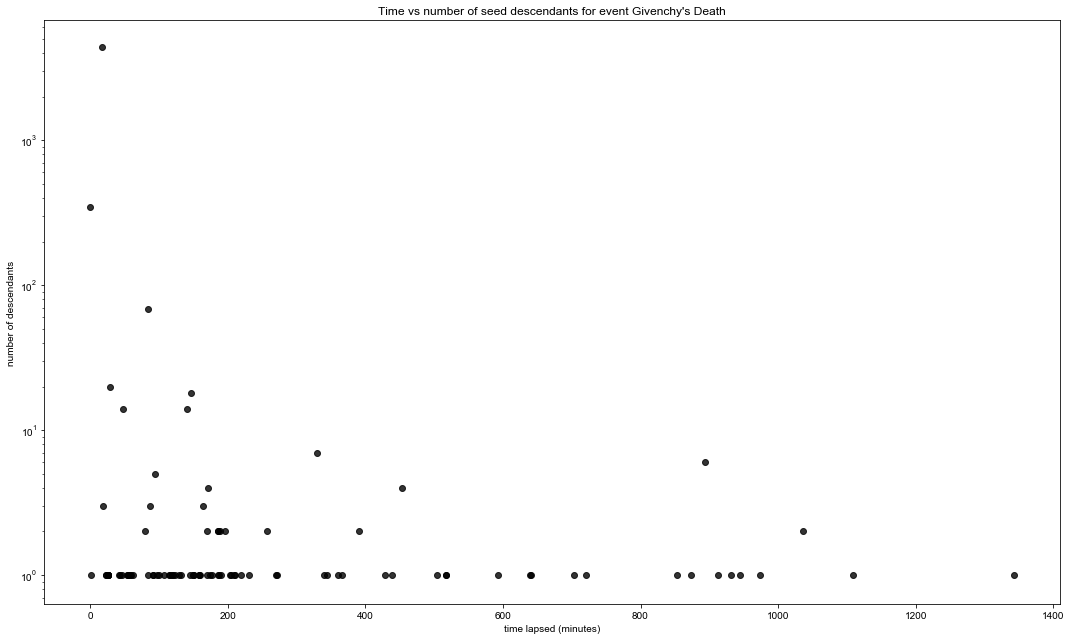

In [45]:
def plot_time_vs_log_seed_descedants(network):
    title = 'Time vs number of seed descendants for event {}'.format(project_name)
    seed_count_series = network.seed_index.value_counts()
    seeds_dataframe = unique_users[network.generation == 0].copy()
    seeds_dataframe['y'] = 0
    for index in seeds_dataframe.index:
        seeds_dataframe.loc[index, 'y'] = seed_count_series.get(index)
    # use the function regplot to make a scatterplot
    sns.regplot(x=seeds_dataframe["time_lapsed"], y=seeds_dataframe['y'], fit_reg=False)
    plt.xlabel('time lapsed (minutes)')
    plt.ylabel('number of descendants')
    plt.yscale("log")
    dzcnapy.plot(title, [15, 9], save=True)
plot_time_vs_log_seed_descedants(unique_users)

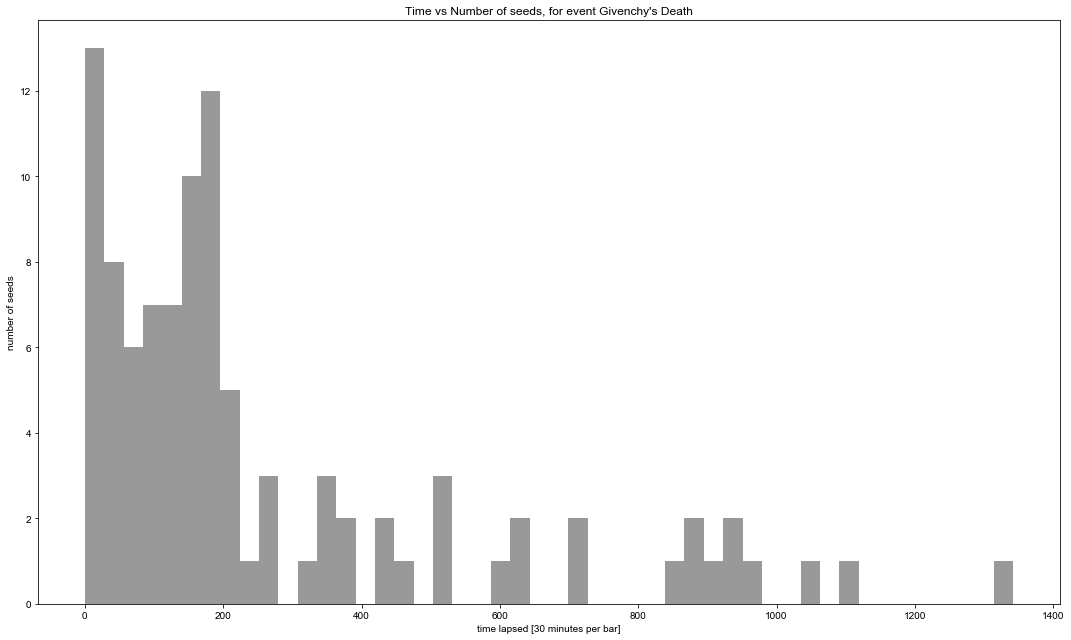

In [8]:
def order_and_reindex(df, column):
    df = df.sort_values(by=[column])
    df = df.set_index(np.arange(len(df.index)))
    return df
def plot_time_vs_number_of_seeds(df):
    title = 'Time vs Number of seeds, for event {}'.format(project_name)
    seeds_dataframe = unique_users[unique_users.generation == 0].copy()
    seeds_dataframe = order_and_reindex(seeds_dataframe, 'time_lapsed')
    n_bins = math.floor(float(timeframe)/window)
    sns.distplot(seeds_dataframe['time_lapsed'], kde=False, bins=n_bins)
    plt.xlabel('time lapsed [{} minutes per bar]'.format(window))
    plt.ylabel('number of seeds')
    dzcnapy.plot(title, [15, 9], save=True)
plot_time_vs_number_of_seeds(unique_users)

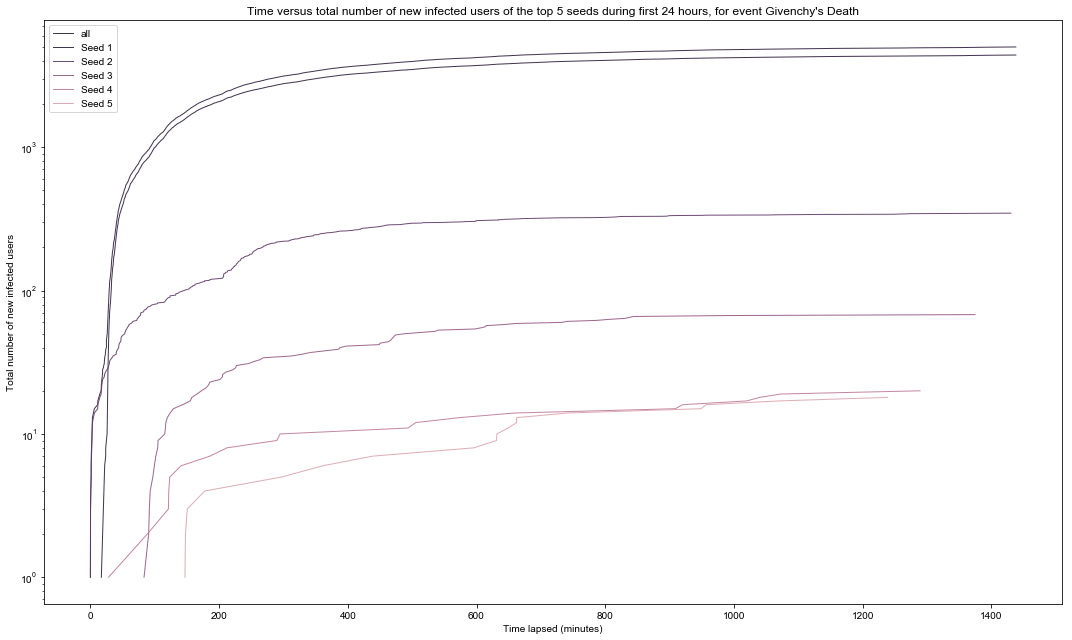

In [42]:
def plot_log_spreading_graph(df):
    title = 'Time versus total number of new infected users of the top 5 seeds during first 24 hours, for event {}'.format(project_name)
    number_of_seeds = 5
    seed_count_series = df.seed_index.value_counts()
    pallttes = sns.cubehelix_palette(number_of_seeds + 1)

    draw_dataframe = df.copy()
    draw_dataframe = draw_dataframe.filter(items=['time_lapsed'])
    draw_dataframe = draw_dataframe.reset_index()
    draw_dataframe['counter'] = range(1, len(draw_dataframe) + 1)
    plt.plot(draw_dataframe['time_lapsed'], draw_dataframe['counter'], marker='', color=pallttes[number_of_seeds], linewidth=1, alpha=0.9, label = 'all')

    for index in range(number_of_seeds):
        seed_index = seed_count_series.keys()[index]
        data_to_plot = df.copy()
        data_to_plot = data_to_plot[data_to_plot.seed_index == seed_index]['time_lapsed']
        data_to_plot = data_to_plot.reset_index()
        data_to_plot['counter'] = range(1, len(data_to_plot) + 1)
        plt.plot(data_to_plot['time_lapsed'], data_to_plot['counter'], marker='', color=pallttes[number_of_seeds - index], linewidth=1, alpha=0.9, label='Seed {}'.format(index + 1))

    plt.xlabel('Time lapsed (minutes)')
    plt.ylabel('Total number of new infected users')
    plt.yscale("log")
    plt.legend()
    dzcnapy.plot(title, [15, 9], save=True)

plot_log_spreading_graph(unique_users)

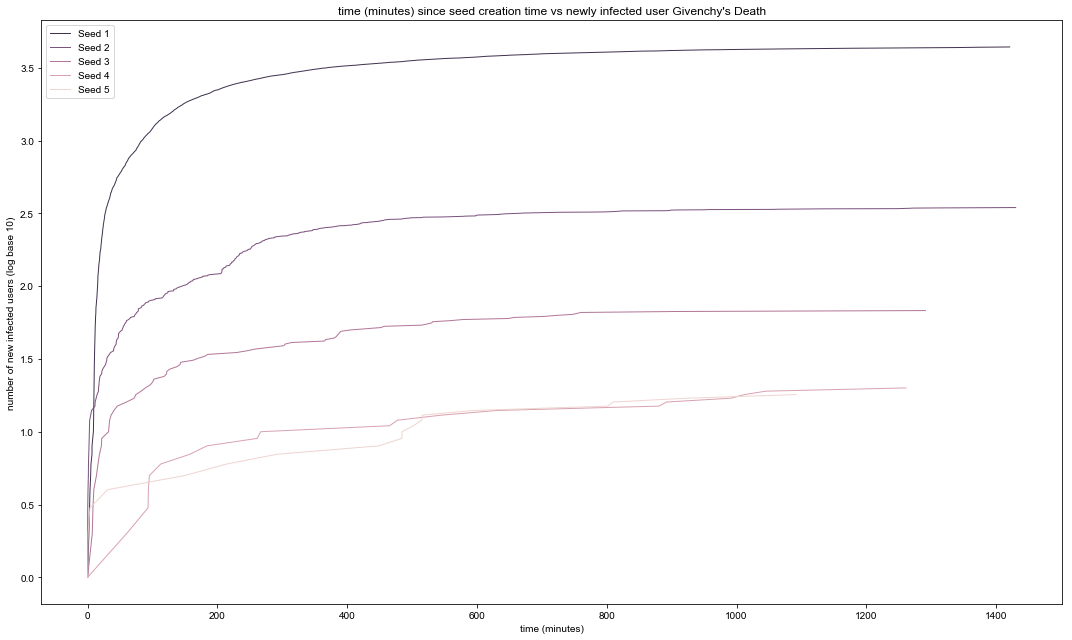

In [40]:
def plot_time_after_spreading_vs_log_10_number_of_newly_infected_user(df):
    title = 'time (minutes) since seed creation time vs newly infected user {}'.format(project_name)
    number_of_seeds = 5
    seed_count_series = df.seed_index.value_counts()
    pallttes = sns.cubehelix_palette(number_of_seeds)
    
    for index in range(number_of_seeds):
        seed_index = seed_count_series.keys()[index]
        data_to_plot = df.copy()
        data_to_plot = data_to_plot[data_to_plot.seed_index == seed_index]['time_since_seed']
        data_to_plot = data_to_plot.reset_index()
        data_to_plot['counter'] = np.log10(range(1, len(data_to_plot) + 1))
        plt.plot(data_to_plot['time_since_seed'], data_to_plot['counter'], marker='', color=pallttes[number_of_seeds - index - 1], linewidth=1, alpha=0.9, label='Seed {}'.format(index + 1))

    plt.title(title)
    plt.xlabel('time (minutes)')
    plt.ylabel('number of new infected users (log base 10)')
    plt.legend()
    dzcnapy.plot(title, [15, 9], save=True)
    
plot_time_after_spreading_vs_log_10_number_of_newly_infected_user(unique_users)

# Seed Details

In [93]:
def plot_seed(x):
    seed_sub_graph = network_all.subgraph(unique_users[(unique_users.seed_index == x)].index)
    title = 'Network diagram for seed at index {}, for event {}'.format(x, project_name)
    plot_network(seed_sub_graph, title)

def plot_seed_bar(x):
    title = 'time lapsed vs newly infected users for seed at index {}, for event {}'.format(x, project_name)
    plt.rcParams['figure.figsize'] = [15, 9]
    d = pd.DataFrame(0, index=np.arange(int(timeframe)/window), columns=range(depth))
    for i in range(int(int(timeframe)/window)):
        data = unique_users[(unique_users.seed_index == x) & (unique_users.time_lapsed >= (i)*window) & (unique_users.time_lapsed < (i+1)*window)]
        for generation in range(depth):
            d.iloc[i, generation] = sum(data.generation == generation)
    ax = d.plot.bar(
        stacked=True, 
        color = get_colors(depth),
        title = title
    );
    ax.set_xticks(range(48))
    ax.set_xticklabels([i*0.5 for i in range(48)])
    ax.set_xlabel('time lapsed (30 mins per bar)')
    ax.set_ylabel('number of newly infected users')
    plt.savefig('{}/{}'.format(config.settings['path']['result'], title))

def top_degree_nodes_in_seed_network(x):
    if save_to_file:
        f = open('{}/top_degree_nodes_for_seed_{}.md'.format(config.settings['path']['result'], x),'w')
    else:
        f = None
    seed_sub_graph = network_all.subgraph(unique_users[(unique_users.seed_index == x)].index)
    top10degree = sorted(dict(nx.degree(seed_sub_graph)).items(), key=operator.itemgetter(1), reverse=True)[0:10]
    print('* Top 10 nodes with largest degree for seed 21', file = f)
    for key, degree in top10degree:
        print('node id: {}, {}, generation: {}, time lapsed: {}, degree: {}, number of descendants: {}'.format(
            key,
            seed_sub_graph.nodes()[key]['user'],
            seed_sub_graph.nodes()[key]['generation'],
            seed_sub_graph.nodes()[key]['time_lapsed'],
            seed_sub_graph.degree(key),
            len(nx.descendants(network_all, key)),
        ), file = f)
    if save_to_file:
        f.close()

def calculate_forward_graph(seed_index):
    seed_forward_network = nx.DiGraph()
    seed_forward_network.add_node(seed_index,
                                  user = unique_users.loc[seed_index, 'user'],
                                  user_id = unique_users.loc[seed_index, 'user_id'],
                                  time_lapsed = unique_users.loc[seed_index, 'time_lapsed'],
                                  followers_count = unique_users.loc[seed_index, 'followers_count'],
                                  friends_count = unique_users.loc[seed_index, 'friends_count'],
                                  generation = 0,
                                  time_since_seed = unique_users.loc[seed_index, 'time_since_seed']
                                 )
    for index in range(seed_index, len(unique_users)):
        source_candidates = [x for x in unique_users.iloc[index].source_candidates if x in seed_forward_network.nodes()]
        if len(source_candidates) > 0:
            source = min(source_candidates)
            source_generation = seed_forward_network.nodes()[source]['generation']
            seed_forward_network.add_node(index,
                                     user = unique_users.loc[index, 'user'],
                                     user_id = unique_users.loc[index, 'user_id'],
                                     time_lapsed = unique_users.loc[index, 'time_lapsed'],
                                     followers_count = unique_users.loc[index, 'followers_count'],
                                     friends_count = unique_users.loc[index, 'friends_count'],
                                     generation = source_generation + 1,
                                     time_since_seed = unique_users.loc[index, 'time_since_seed'],
                                    )
            seed_forward_network.add_edge(source, index)
    return seed_forward_network


def forward_graph_for_seed(g, x):
    number_of_nodes = len(g.nodes())
    plot_network(g, 'Forward spreading for seed at index {}, [{} of {} nodes]'.format(x, number_of_nodes, total_nodes))
    
    
def plot_forward_bar(g, x):
    title = 'Forward spreading bar for seed at index {}'.format(x)
    plt.rcParams['figure.figsize'] = [15, 9]
    network = pd.DataFrame(data = {
        'time_lapsed': list(nx.get_node_attributes(g,'time_lapsed').values()), 
        'generation': list(nx.get_node_attributes(g,'generation').values())
    })
    
    depth = max(network.generation)
    d = pd.DataFrame(0, index=np.arange(int(timeframe)/window), columns=range(depth))
    for i in range(int(int(timeframe)/window)):
        data = network[(network.time_lapsed >= (i)*window) & (network.time_lapsed < (i+1)*window)]
        for generation in range(depth):
            d.iloc[i, generation] = sum(data.generation == generation)
    colors = get_colors(depth)
    ax = d.plot.bar(
        stacked=True, 
        color = colors
    );
    ax.set_xticks(range(48))
    ax.set_xticklabels([i*0.5 for i in range(48)])
    ax.set_xlabel('time lapsed (30 mins per bar)')
    ax.set_ylabel('number of newly infected users')
    patchList = []
    for index in range(depth):
        data_key = mpatches.Patch(color=colors[index], label='Generation {}'.format(index))
        patchList.append(data_key)
    plt.legend(handles=patchList)
    dzcnapy.plot(title, [15, 9], save=True)

## 1st Largest Seed

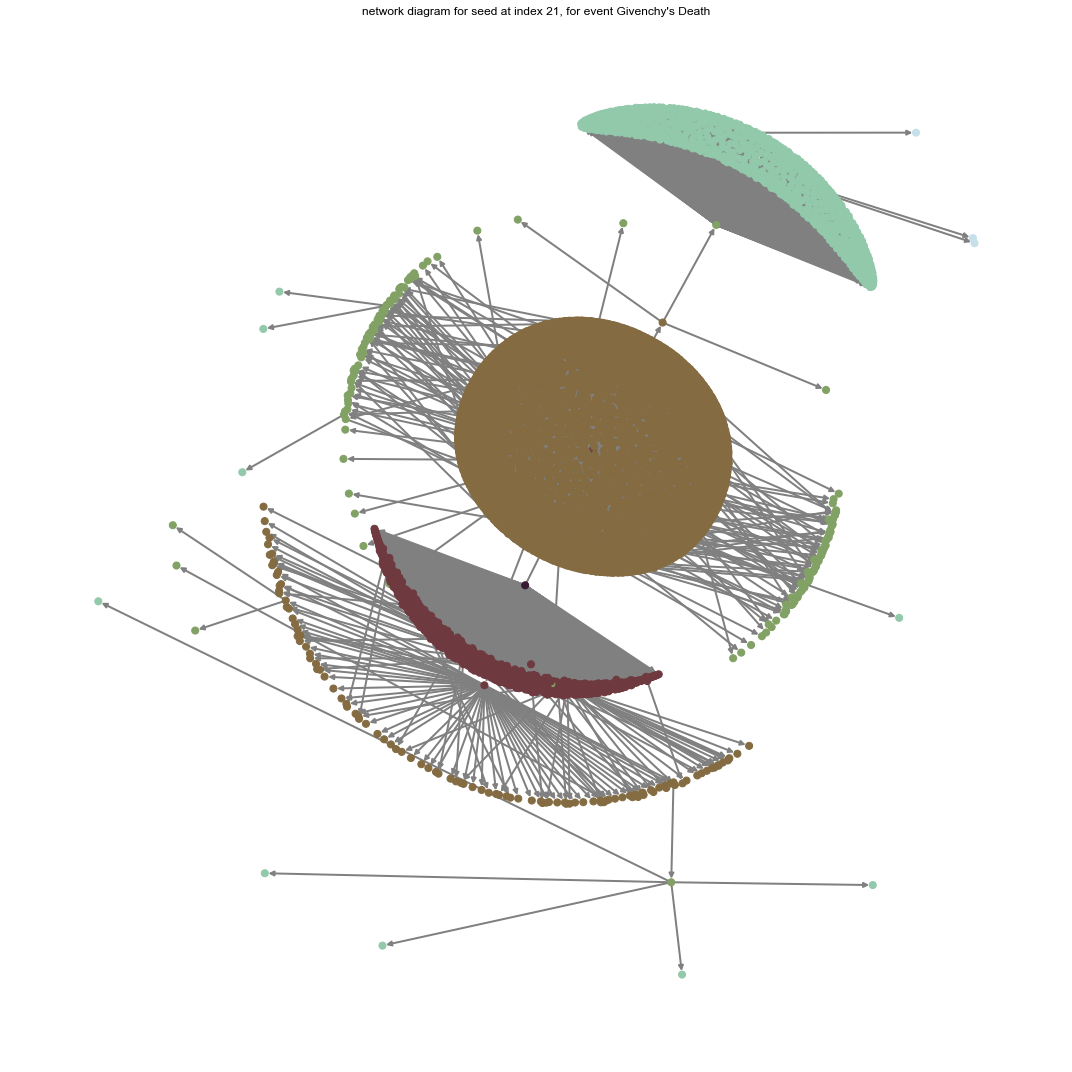

In [20]:
plot_seed(top10seeds.keys()[0])

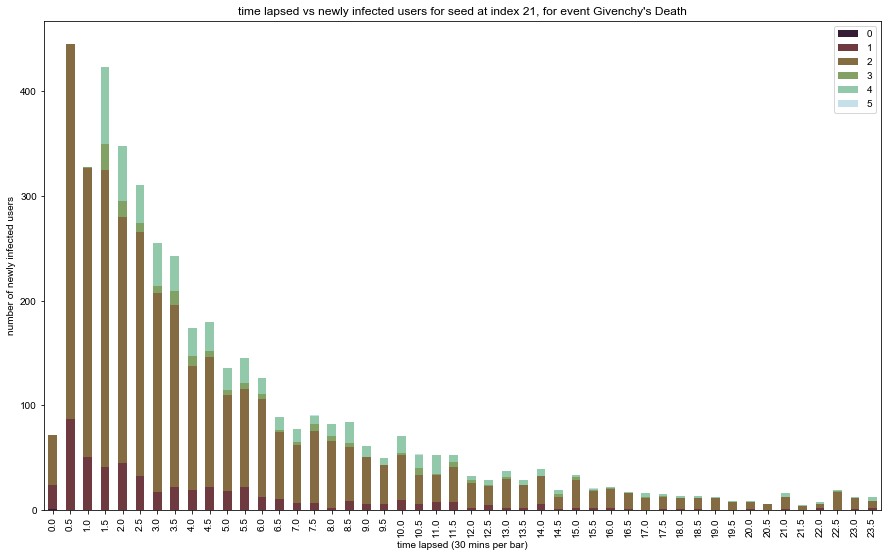

In [49]:
plot_seed_bar(top10seeds.keys()[0])

In [69]:
top_degree_nodes_in_seed_network(top10seeds.keys()[0])

* Top 10 nodes with largest degree for seed 21
node id: 48, IAMFASHlON, generation: 1, time lapsed: 25.9, degree: 3066, number of descendants: 3753
node id: 972, MEENAVOGUEE, generation: 3, time lapsed: 91.42, degree: 537, number of descendants: 539
node id: 21, Fashionista_com, generation: 0, time lapsed: 17.0, degree: 528, number of descendants: 4401
node id: 748, harpersbazaarus, generation: 1, time lapsed: 72.85, degree: 53, number of descendants: 60
node id: 71, vintagevogues, generation: 2, time lapsed: 27.67, degree: 30, number of descendants: 29
node id: 115, TokyoFashion, generation: 1, time lapsed: 29.92, degree: 18, number of descendants: 17
node id: 1929, ninagarcia, generation: 1, time lapsed: 160.12, degree: 15, number of descendants: 14
node id: 819, fleursetart, generation: 2, time lapsed: 78.15, degree: 13, number of descendants: 12
node id: 568, givemethecoins, generation: 2, time lapsed: 57.83, degree: 8, number of descendants: 7
node id: 499, VSAngelsBrasil, generat

In [86]:
g = calculate_forward_graph(top10seeds.keys()[0])

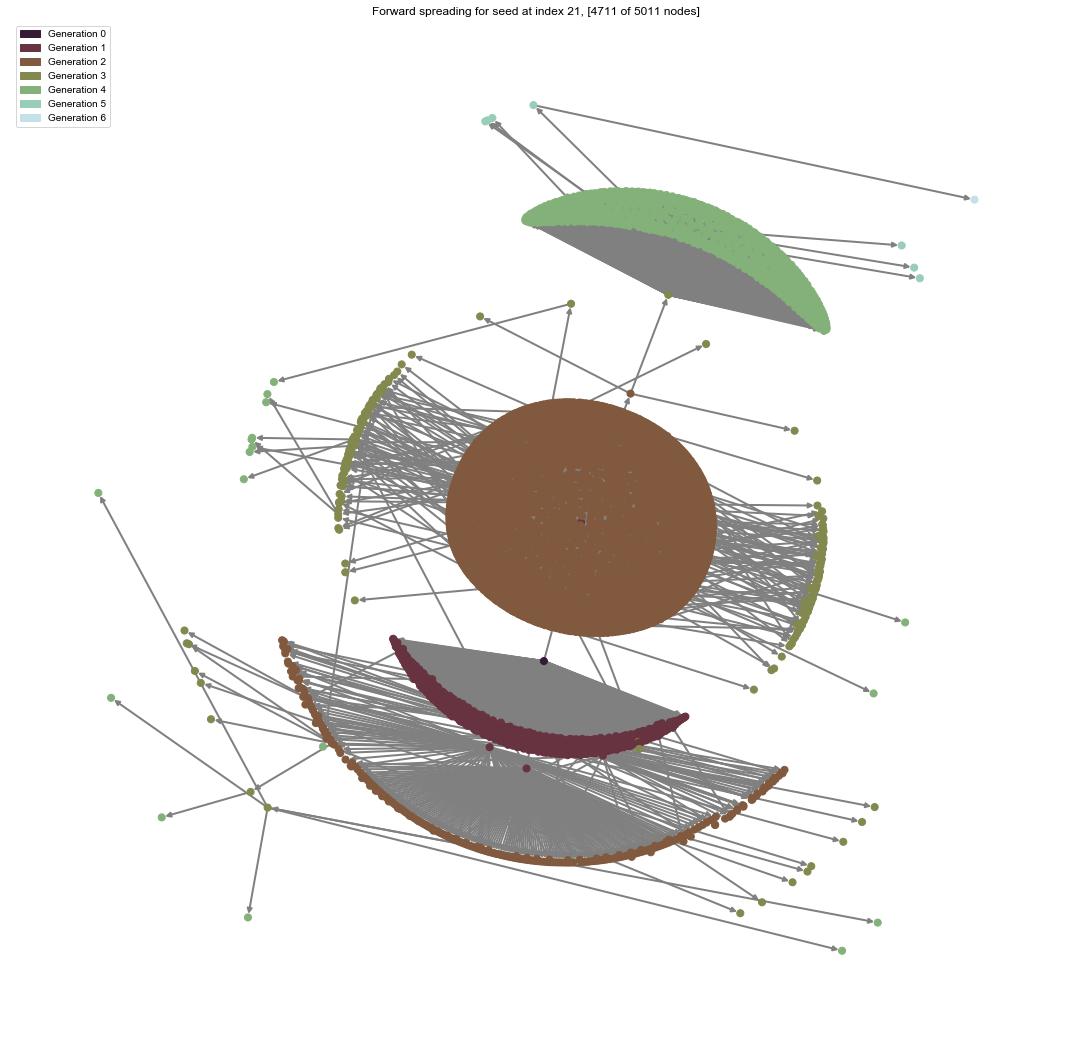

In [94]:
forward_graph_for_seed(g, top10seeds.keys()[0])

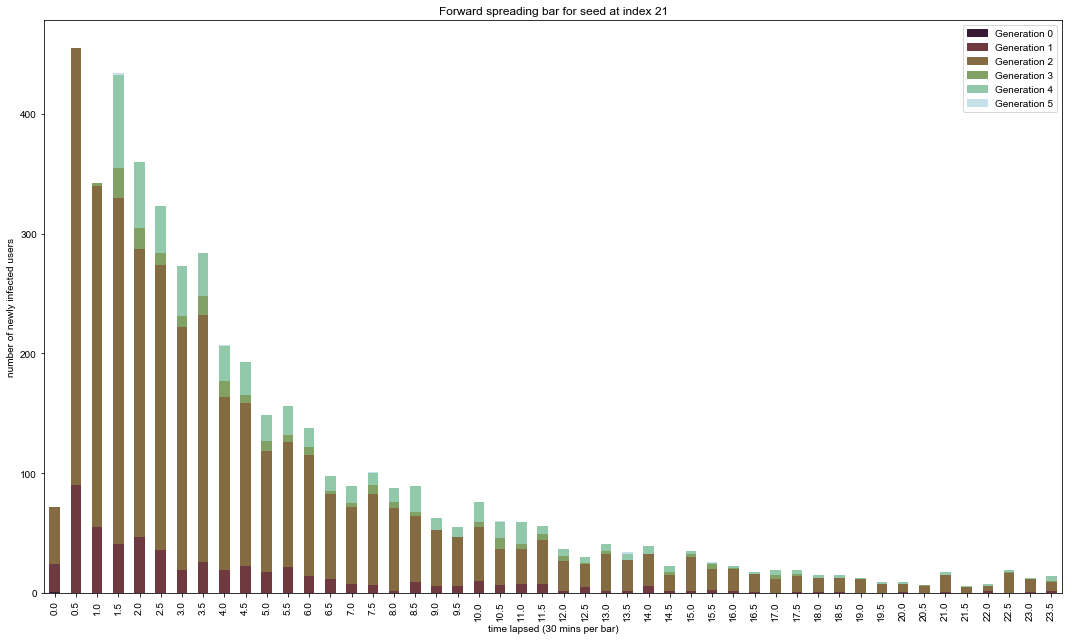

In [95]:
plot_forward_bar(g, top10seeds.keys()[0])

## 2nd Largest Seed

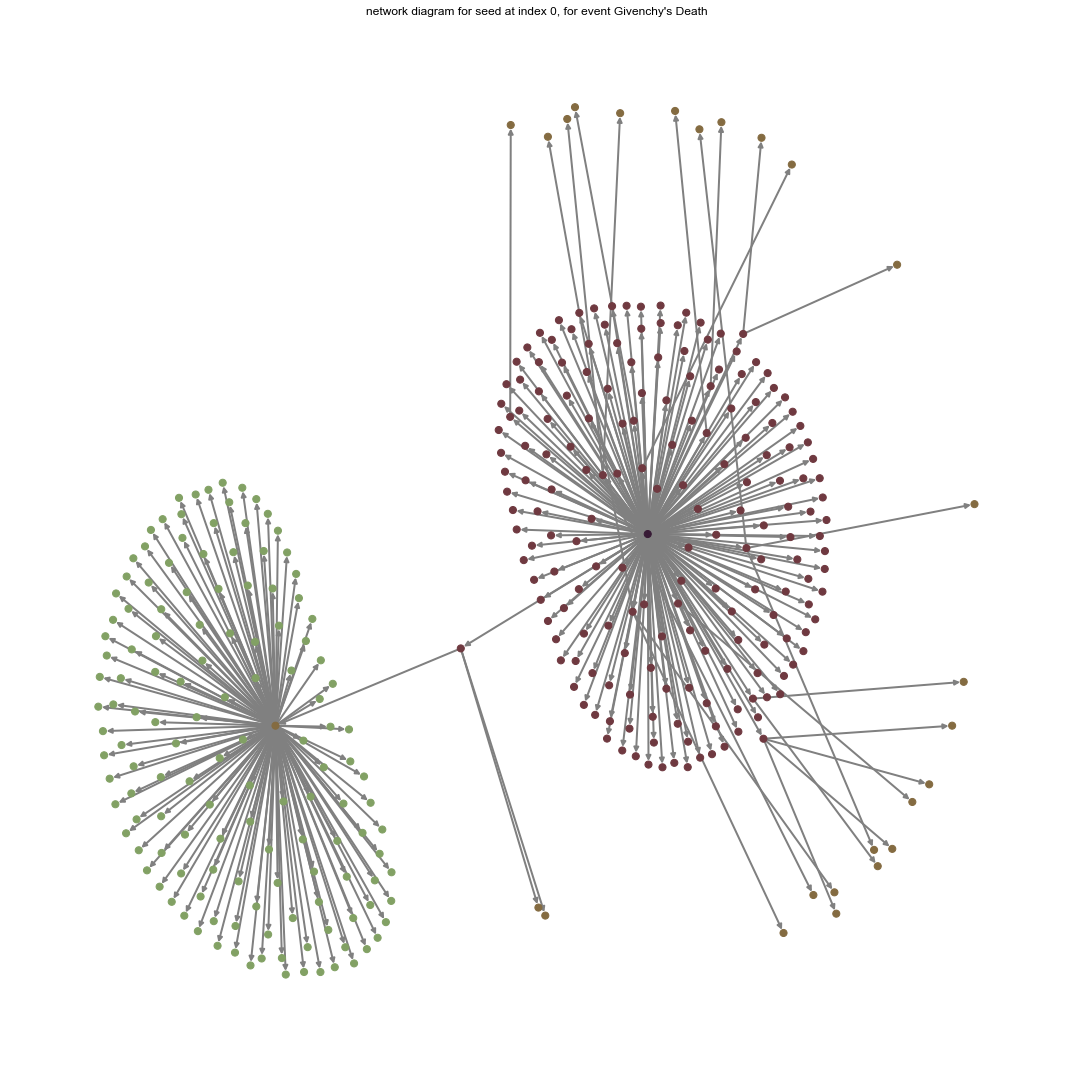

In [26]:
plot_seed(top10seeds.keys()[1])

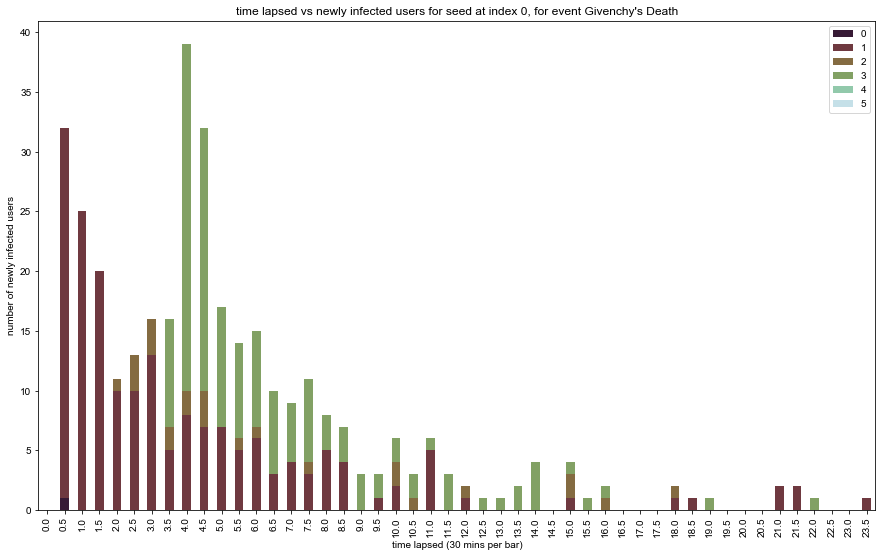

In [27]:
plot_seed_bar(top10seeds.keys()[1])

In [70]:
top_degree_nodes_in_seed_network(top10seeds.keys()[1])

* Top 10 nodes with largest degree for seed 21
node id: 0, davelackie, generation: 0, time lapsed: 0.0, degree: 183, number of descendants: 346
node id: 2358, supermodeldaiIy, generation: 2, time lapsed: 205.12, degree: 138, number of descendants: 137
node id: 12, ShinyStew, generation: 1, time lapsed: 3.17, degree: 5, number of descendants: 4
node id: 2, consiglierela, generation: 1, time lapsed: 0.23, degree: 4, number of descendants: 140
node id: 6, Gwen_UsBeauty, generation: 1, time lapsed: 1.32, degree: 4, number of descendants: 3
node id: 30, Moongawddess_, generation: 1, time lapsed: 21.53, degree: 4, number of descendants: 3
node id: 426, blancversace, generation: 1, time lapsed: 47.63, degree: 4, number of descendants: 3
node id: 335, beauty_jackson, generation: 1, time lapsed: 42.38, degree: 3, number of descendants: 2
node id: 1022, LindaLeeKing, generation: 1, time lapsed: 94.35, degree: 3, number of descendants: 2
node id: 5, panagiota_karag, generation: 1, time lapsed: 1.

In [106]:
g = calculate_forward_graph(top10seeds.keys()[1])

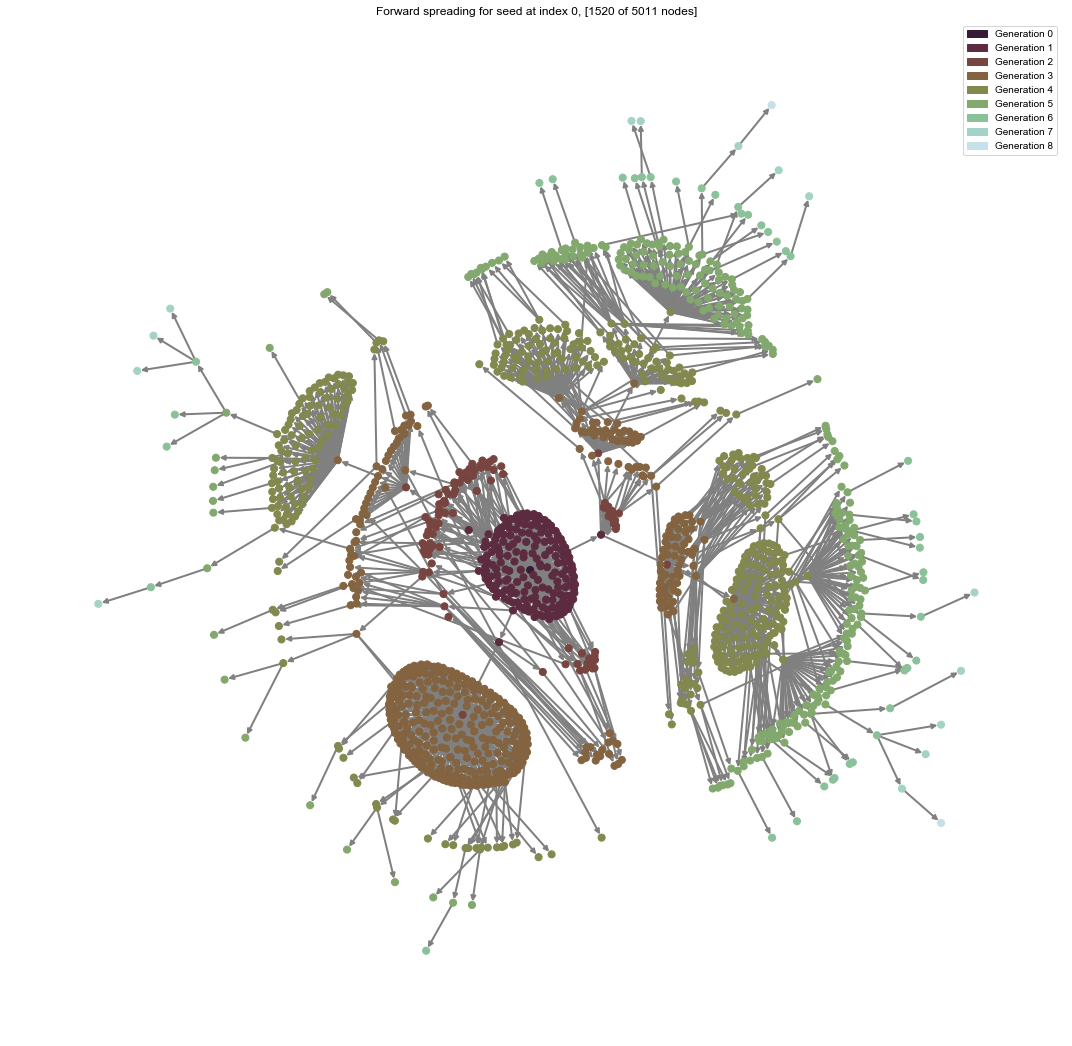

In [107]:
forward_graph_for_seed(g, top10seeds.keys()[1])

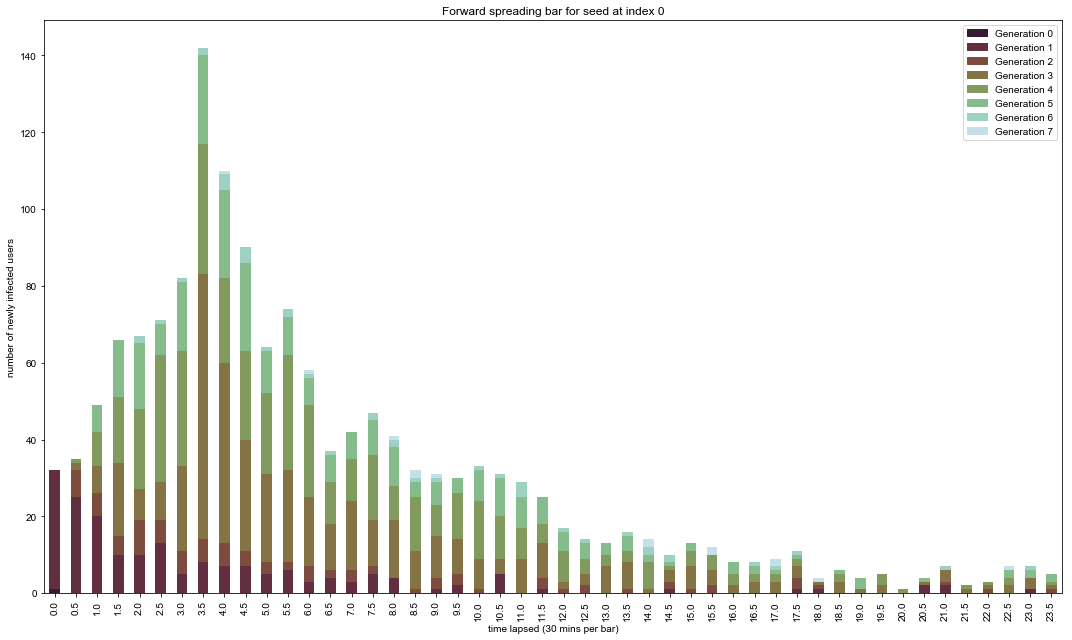

In [105]:
plot_forward_bar(g, top10seeds.keys()[1])

## 3rd Largest Seed

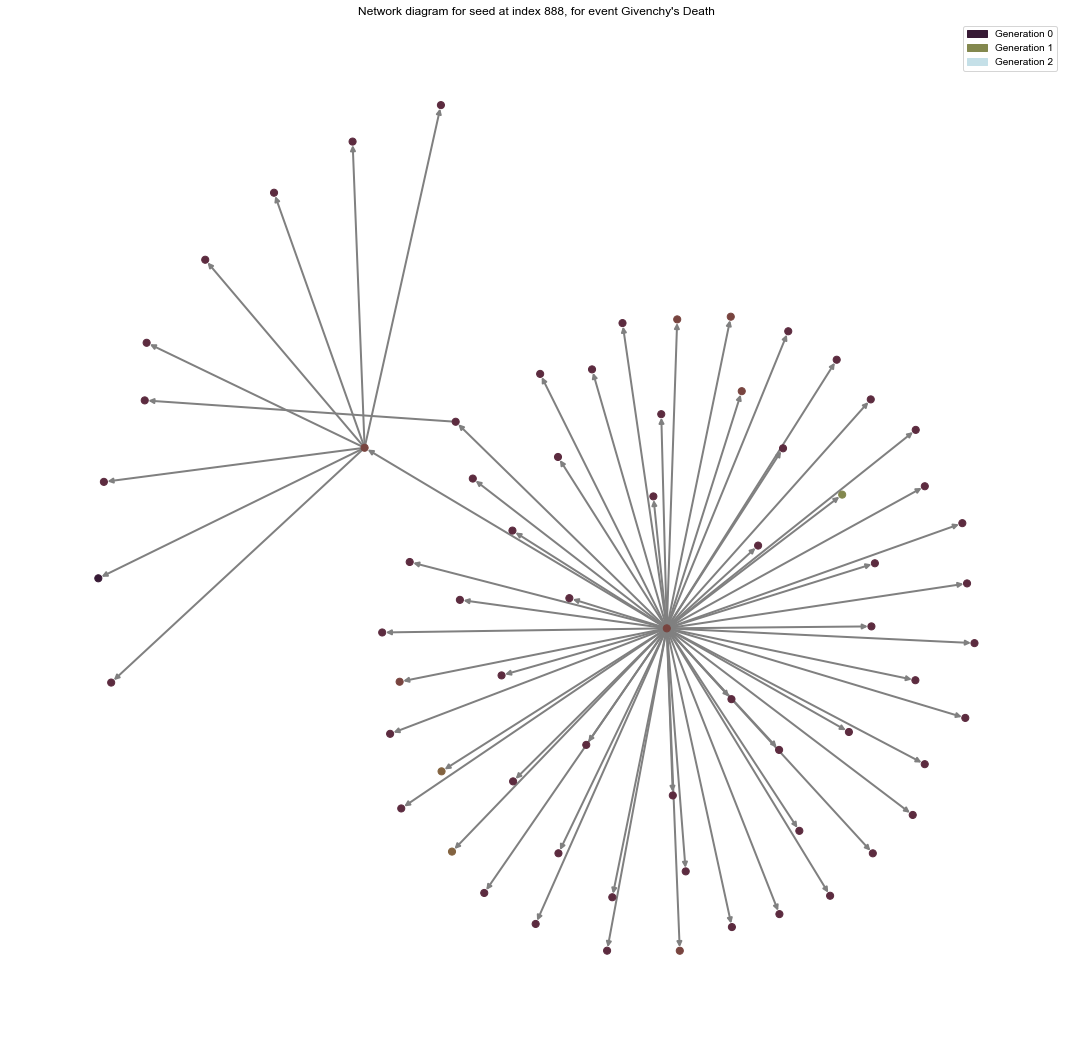

In [100]:
plot_seed(top10seeds.keys()[2])

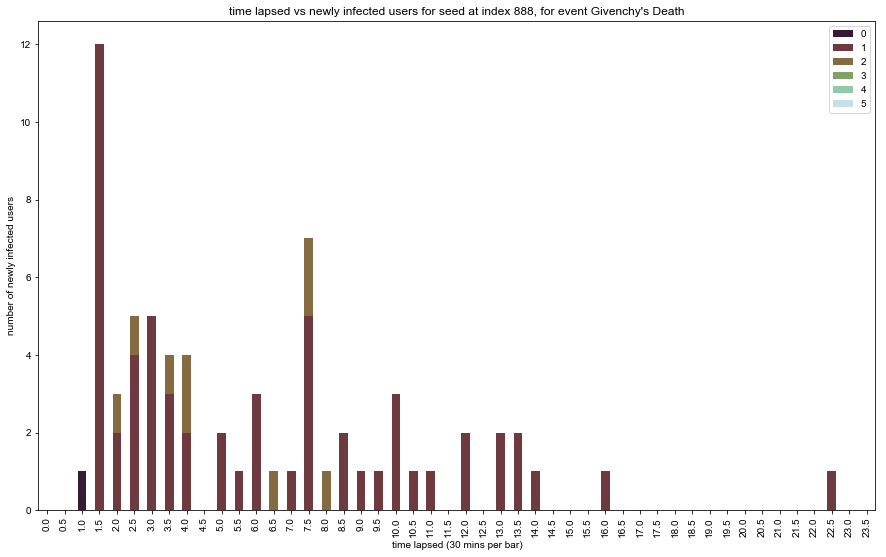

In [108]:
plot_seed_bar(top10seeds.keys()[2])

In [109]:
top_degree_nodes_in_seed_network(top10seeds.keys()[2])

* Top 10 nodes with largest degree for seed 21
node id: 888, miuyorker, generation: 0, time lapsed: 83.35, degree: 58, number of descendants: 67
node id: 961, saabcouture, generation: 1, time lapsed: 90.53, degree: 9, number of descendants: 8
node id: 1136, beyissues, generation: 1, time lapsed: 101.62, degree: 2, number of descendants: 1
node id: 1540, JordynSearss, generation: 2, time lapsed: 128.98, degree: 1, number of descendants: 0
node id: 4101, JazzCrichton, generation: 1, time lapsed: 540.03, degree: 1, number of descendants: 0
node id: 2189, dudagrecoo, generation: 1, time lapsed: 185.62, degree: 1, number of descendants: 0
node id: 2446, empang__, generation: 2, time lapsed: 210.57, degree: 1, number of descendants: 0
node id: 2829, india_wick, generation: 1, time lapsed: 254.0, degree: 1, number of descendants: 0
node id: 3597, Here_with_Larry, generation: 1, time lapsed: 387.63, degree: 1, number of descendants: 0
node id: 3853, leighadecookie, generation: 1, time lapsed: 

In [122]:
g = calculate_forward_graph(top10seeds.keys()[2])

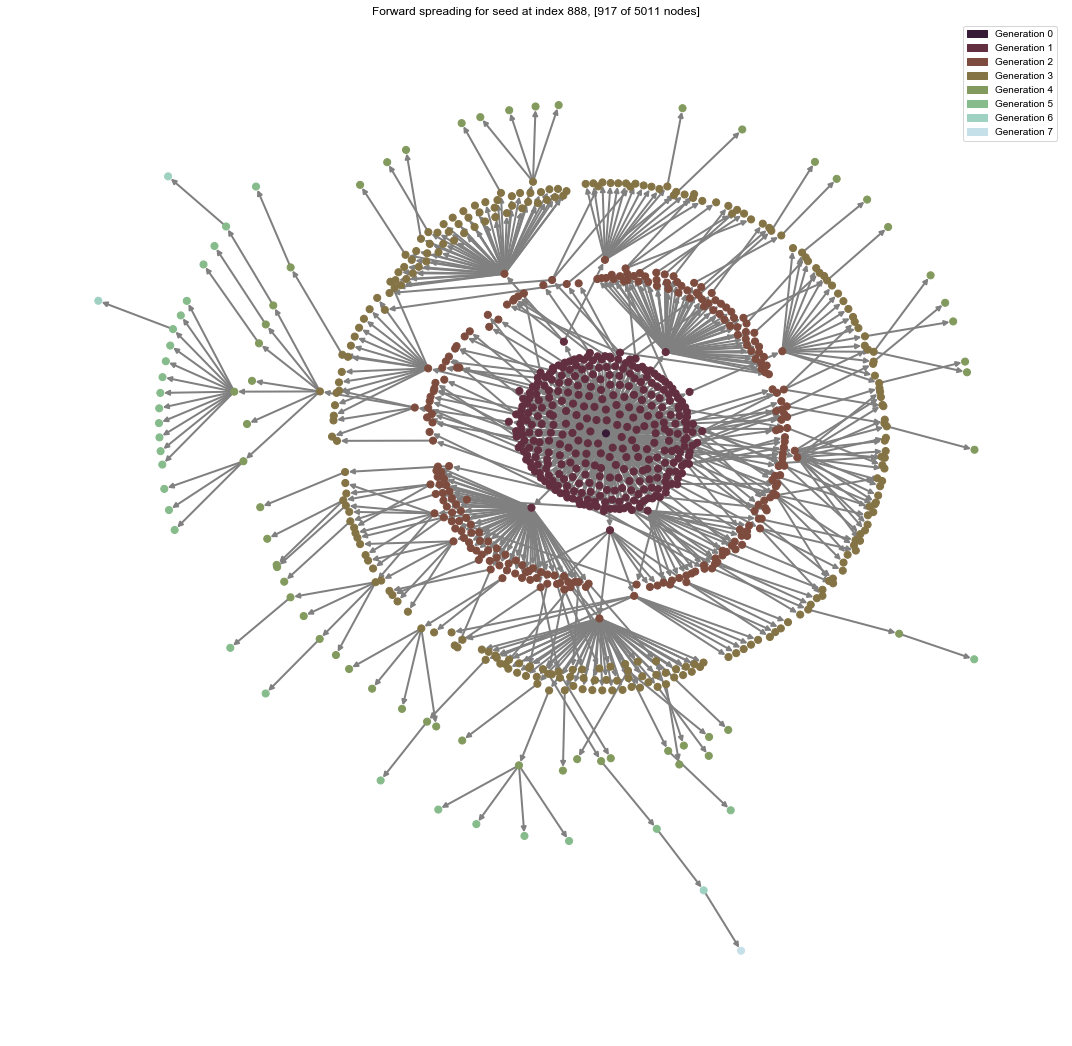

In [123]:
forward_graph_for_seed(g, top10seeds.keys()[2])

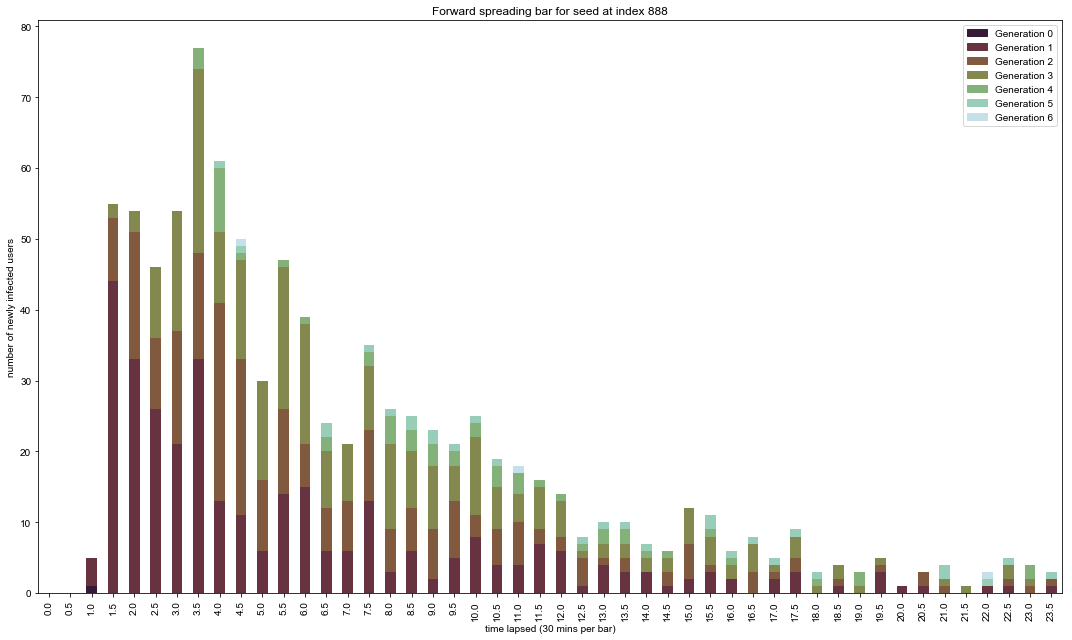

In [124]:
plot_forward_bar(g, top10seeds.keys()[2])